In [8]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
from astropy.io import fits

import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import emcee

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph, center_deemph

import arviz as az
import kinesis as kn
import gapipes as gp

In [3]:
mike_data = Table.read('../data/mike_final.fits')
mike_data['pw1_id'] = [int(x.strip()[-2:]) if 'pw' in x else 9999 for x in mike_data['NAME']]

data = Table.read('../output/pw1-region-data-joined.fits')
data['pw1_id'] = [int(x.strip()[-2:]) if 'PW' in x else 9999 for x in data['pw1_name']]

In [4]:
all_tbl = join(data, mike_data, keys='pw1_id')
mike_tbl = all_tbl[all_tbl['pw1_name'] != '']
tbl = mike_tbl[mike_tbl['SNR_RES'] > 10]
len(tbl)

22

In [7]:
def ln_normal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def robust_ln_prob(p, tbl):
    lnf, mu, lns = p
    s = np.exp(lns)
    f = np.exp(lnf)
    
    lp = lnf
    if not -10 < lnf < 0:
        return -np.inf
    lp += ln_normal(mu, -1, 4)
    
    l1 = ln_normal(tbl['FEH'], mu, s) + np.log(f)
    l2 = ln_normal(tbl['FEH'], 0, 5) + np.log(1-f)
    ll = np.logaddexp(l1, l2).sum()
    
    return ll + lp

In [9]:
nwalkers = 64
sampler = emcee.EnsembleSampler(nwalkers, ndim=3, log_prob_fn=robust_ln_prob, args=(tbl, ))
p0 = emcee.utils.sample_ball([np.log(0.9), -1.16, np.log(0.1)], [1e-3]*3, size=nwalkers)

In [13]:
pos, *_ = sampler.run_mcmc(p0, 128, progress=True)
sampler.reset()
_ = sampler.run_mcmc(pos, 1024, progress=True)

100%|██████████| 1024/1024 [00:14<00:00, 70.68it/s]


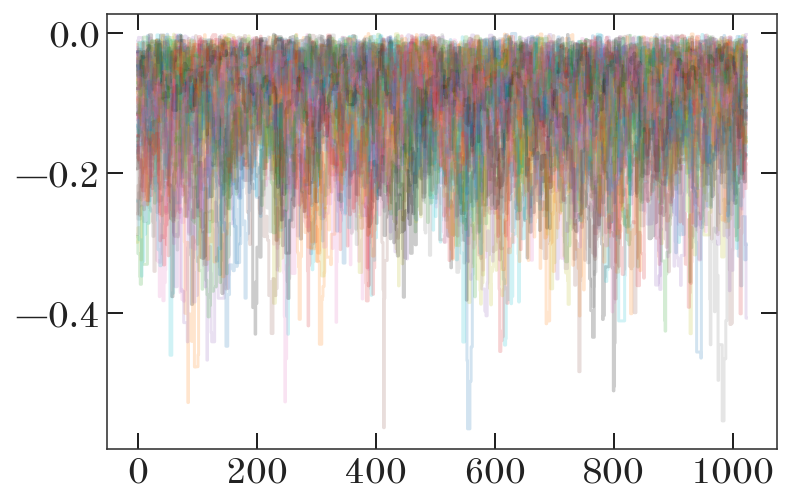

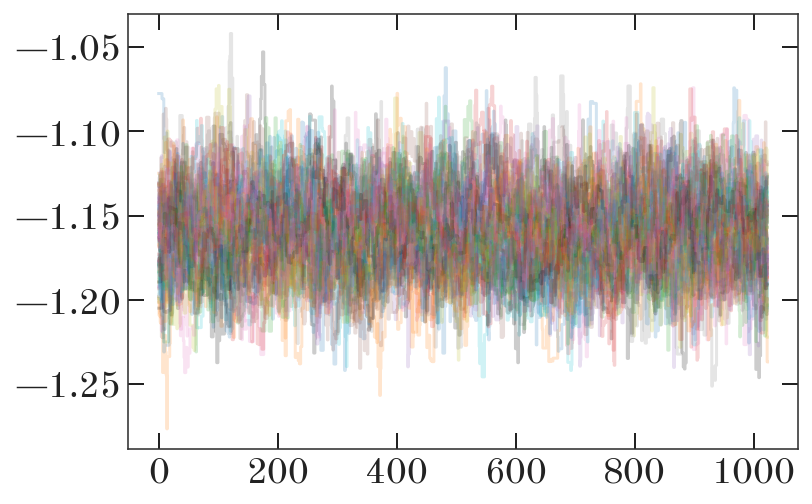

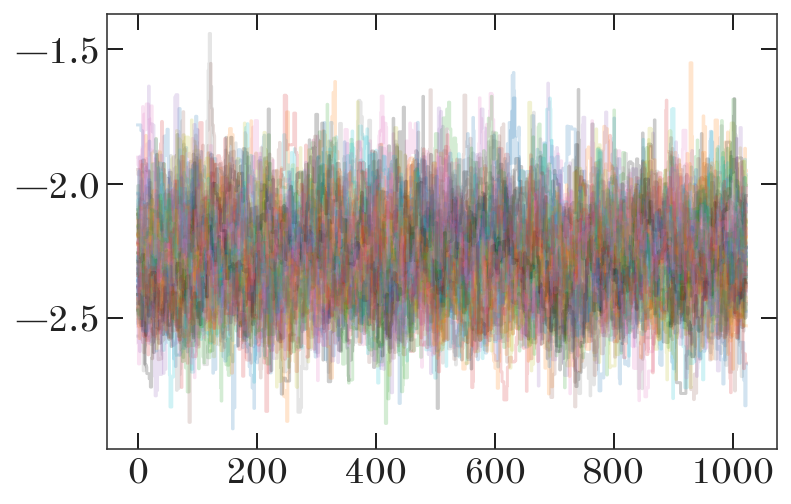

In [14]:
for k in range(3):
    plt.figure()
    for walker in sampler.chain[..., k]:
        plt.plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)

In [22]:
flatchain = np.vstack(sampler.chain[:, ::32])
flatchain[:, 0] = np.exp(flatchain[:, 0])
flatchain[:, 2] = np.exp(flatchain[:, 2])

In [23]:
np.mean(flatchain, axis=0)

array([ 0.90886129, -1.15991007,  0.10408693])

In [24]:
np.std(flatchain, axis=0)

array([0.05949514, 0.02335523, 0.01830683])

In [28]:
tbl.colnames

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

Text(0.5, 0, '$v_{\\rm helio}$ [$\\mathrm{km\\,s^{-1}}$]')

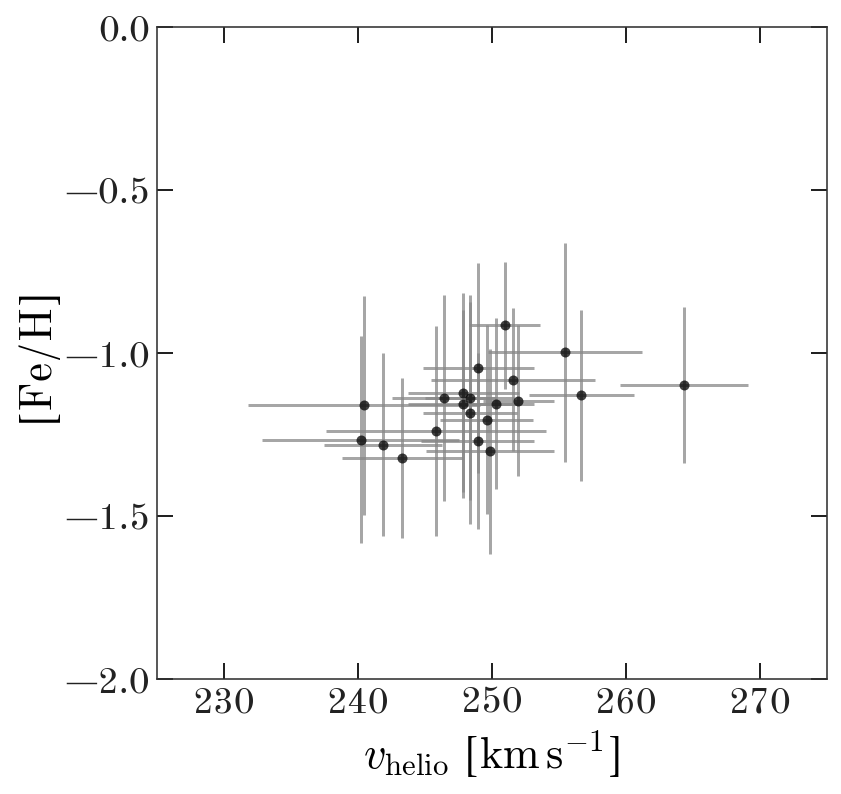

In [40]:
plt.figure(figsize=(6, 6))
plt.errorbar(tbl['VHELIO'], tbl['FEH'],
             xerr=tbl['VERR'], yerr=tbl['FEHERR'],
             ls='none', marker='o', ecolor='#888888', 
             alpha=0.75)

plt.xlim(225, 275)
plt.ylim(-2, 0)

ax = plt.gca()
ax.yaxis.set_ticks(np.arange(-2, 0+1e-3, 0.5))
ax.xaxis.set_ticks(np.arange(230, 270+1e-3, 10))

ax.set_ylabel(r'[Fe/H]')
ax.set_xlabel(r'$v_{\rm helio}$ ' + '[{:latex_inline}]'.format(u.km/u.s))